# Introduction

This notebook outlines how to explain the results of a recommendation system built using a Factorization Machine (FM) model in Amazon SageMaker.

There are four parts to this notebook:

1. Building a FM Model
2. Extracting FM model parameters
3. Building the influence matrix
4. Explaining recommendations for a user

## Data sources and citations

I used three primary sources for this notebook.

### How to build and extract FM model

[Extending Amazon SageMaker factorization machines algorithm to predict top x recommendations](https://aws.amazon.com/blogs/machine-learning/extending-amazon-sagemaker-factorization-machines-algorithm-to-predict-top-x-recommendations/), published on the AWS Machine Learning Blog by Zohar Karnin and Rama Thamman on April 5, 2019.  This blog has a sample notebook for building the FM model for the movie lens dataset and extracting the FM model parameters.  I am repeating Parts 1 and 2 from that notebook for the sake of being able to reproduce the entire workflow in a single notebook.

### How to build influence matrix

I implemented the technique in this paper for building the influence matrix:

Bashir Rastegarpanah, Mark Crovella, Krishna Gummadi. 2017. "Exploring Explanations for Matrix Factorization Recommender Systems (Position Paper)." Proceedings of the FATREC Workshop on Responsible Recommendation.  Retrieved on October 7, 2019, from https://hdl.handle.net/2144/26683.


### Data set

The blog published by Karnin and Thamman uses the GroupLens movie dataset, available on https://grouplens.org/datasets/movielens/.  Per the terms of reuse, we do not redistribute the data set here, but rather provide code to download it.  The dataset formal citation is:

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

## Part 1 - Building a FM Model using movie lens dataset

This section is reproduced with minor modifications from the blog cited above.  I include it for completeness so you can see how to build the FM model from the source data set.

Be sure to customize the name of the S3 bucket used to upload the data set for FM training.  

In [4]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
data_prefix = 'sagemaker/factorization-machines/movielens/data'

In [5]:
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import json_deserializer
from sagemaker.amazon.amazon_estimator import get_image_uri
import numpy as np
from scipy.sparse import lil_matrix
import pandas as pd
import boto3, io, os

### Download movie rating data from movie lens

In [6]:
#download data
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

--2020-02-01 07:49:18--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  18.2MB/s    in 0.3s    

2020-02-01 07:49:18 (18.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

### Shuffle the data

In [7]:
!shuf ml-100k/ua.base -o ml-100k/ua.base.shuffled

### Load Training Data

In [8]:
user_movie_ratings_train = pd.read_csv('ml-100k/ua.base.shuffled', sep='\t', index_col=False, 
                 names=['user_id' , 'movie_id' , 'rating'])
user_movie_ratings_train.head(5)

,user_id,movie_id,rating
0,416,842,4
1,619,11,2
2,222,769,2
3,716,47,3
4,577,588,4


### Load Test Data

In [9]:
user_movie_ratings_test = pd.read_csv('ml-100k/ua.test', sep='\t', index_col=False, 
                 names=['user_id' , 'movie_id' , 'rating'])
user_movie_ratings_test.head(5)

,user_id,movie_id,rating
0,1,20,4
1,1,33,4
2,1,61,4
3,1,117,3
4,1,155,2


In [10]:
nb_users= user_movie_ratings_train['user_id'].max()
nb_movies=user_movie_ratings_train['movie_id'].max()
nb_features=nb_users+nb_movies
nb_ratings_test=len(user_movie_ratings_test.index)
nb_ratings_train=len(user_movie_ratings_train.index)
print(" # of users: ", nb_users)
print(" # of movies: ", nb_movies)
print(" Training Count: ", nb_ratings_train)
print(" Test Count: ", nb_ratings_test)
print(" Features (# of users + # of movies): ", nb_features)

(' # of users: ', 943)
(' # of movies: ', 1682)
(' Training Count: ', 90570)
(' Test Count: ', 9430)
(' Features (# of users + # of movies): ', 2625)


### FM Input

Input to FM is a one-hot encoded sparse matrix. Only ratings 4 and above are considered for the model. We will be ignoring ratings 3 and below.

In [11]:
def loadDataset(df, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line=0
    for index, row in df.iterrows():
            X[line,row['user_id']-1] = 1
            X[line, nb_users+(row['movie_id']-1)] = 1
            if int(row['rating']) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line=line+1

    Y=np.array(Y).astype('float32')            
    return X,Y


X_train, Y_train = loadDataset(user_movie_ratings_train, nb_ratings_train, nb_features)
X_test, Y_test = loadDataset(user_movie_ratings_test, nb_ratings_test, nb_features)

In [12]:
print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (nb_ratings_train, nb_features)
assert Y_train.shape == (nb_ratings_train, )
zero_labels = np.count_nonzero(Y_train)
print("Training labels: %d zeros, %d ones" % (zero_labels, nb_ratings_train-zero_labels))

print(X_test.shape)
print(Y_test.shape)
assert X_test.shape  == (nb_ratings_test, nb_features)
assert Y_test.shape  == (nb_ratings_test, )
zero_labels = np.count_nonzero(Y_test)
print("Test labels: %d zeros, %d ones" % (zero_labels, nb_ratings_test-zero_labels))

(90570, 2625)
(90570,)
Training labels: 49906 zeros, 40664 ones
(9430, 2625)
(9430,)
Test labels: 5469 zeros, 3961 ones


### Convert to Protobuf format for saving to S3

In [13]:
prefix = 'fm'

if bucket.strip() == '':
    raise RuntimeError("bucket name is empty.")

train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test')

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

In [14]:
def writeDatasetToProtobuf(X, bucket, prefix, key, d_type, Y=None):
    buf = io.BytesIO()
    if d_type == "sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
fm_train_data_path = writeDatasetToProtobuf(X_train, bucket, train_prefix, train_key, "sparse", Y_train)    
fm_test_data_path  = writeDatasetToProtobuf(X_test, bucket, test_prefix, test_key, "sparse", Y_test)    
  
print("Training data S3 path: ",fm_train_data_path)
print("Test data S3 path: ",fm_test_data_path)
print("FM model output S3 path: {}".format(output_prefix))

('Training data S3 path: ', 's3://sagemaker-us-east-1-835319576252/fm/train/train.protobuf')
('Test data S3 path: ', 's3://sagemaker-us-east-1-835319576252/fm/test/test.protobuf')
FM model output S3 path: s3://sagemaker-us-east-1-835319576252/fm/output


### Run training job

You can play around with the hyper parameters until you are happy with the prediction. For this dataset and hyper parameters configuration, after 200 epochs, test accuracy was around 70% on average and the F1 score (a typical metric for a binary classifier) was around 0.75 (1 indicates a perfect classifier). Not great, but you can fine tune the model further.

If you've already run the training job, you can load it rather than running the job again.  Just set the `model_uri` parameter to the location of the model artifact, and set the flag `model_exists` to `True`.

Similarly, if you already have a prediction endpoint available, set the flag `model_deployed` to `True` and provide the `model_endpoint` parameter.

In [21]:
model_exists = True
model_uri = 's3://{}/factorization-machines/movielens/output/factorization-machines-2019-10-10-22-13-15-602/output/model.tar.gz'.format(bucket)
model_deployed = True
#model_endpoint = 'factorization-machines-2019-10-11-15-27-16-815' 
#if model_exists:
#    fm_model = sagemaker.FactorizationMachinesModel(model_uri, get_execution_role(), sagemaker_session=sagemaker.Session())
    
#    if model_deployed:
#        fm_predictor =  sagemaker.predictor.RealTimePredictor(model_endpoint, sagemaker_session=sagemaker.Session())
#    else:
#        fm_predictor = fm_model.deploy(initial_instance_count=1,
#                         instance_type='ml.m5.xlarge')
#else:
fm = sagemaker.estimator.Estimator(get_image_uri(boto3.Session().region_name, "factorization-machines"),
                               get_execution_role(), 
                               train_instance_count=1, 
                               train_instance_type='ml.m5.xlarge',
                               output_path=output_prefix,
                               sagemaker_session=sagemaker.Session())

In [ ]:
fm.set_hyperparameters(feature_dim=nb_features,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=200)
fm.fit({'train': fm_train_data_path, 'test': fm_test_data_path})

In [23]:
fm_predictor = fm.deploy(initial_instance_count=1,
                     instance_type='ml.m5.xlarge')

---------------------------------------------------------------------------------------!

In [24]:
import json
from sagemaker.predictor import json_deserializer

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    #print(json.dumps(js))
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

## Part 2 - Extracting parameters from FM model

Now that we have the model created and stored in SageMaker, we can download the same and extract the parameters.  The FM model is stored in MxNet format.

This section is reproduced with minor modifications from the blog cited above for the sake of completeness.

### Download model data

Skip the next cell block if you have already downloaded the model.

In [25]:
import mxnet as mx
model_file_name = "model.tar.gz"
model_full_path = fm.output_path +"/"+ fm.latest_training_job.job_name +"/output/"+model_file_name
print("Model Path: ", model_full_path)

#Download FM model 
os.system("aws s3 cp "+model_full_path+ " .")

#Extract model file for loading to MXNet
os.system("tar xzvf "+model_file_name)
os.system("unzip -o model_algo-1")
os.system("mv symbol.json model-symbol.json")
os.system("mv params model-0000.params")

('Model Path: ', 's3://sagemaker-us-east-1-835319576252/fm/output/factorization-machines-2020-02-01-07-53-14-840/output/model.tar.gz')


0

### Extract model data to create item and user latent matrixes

In [26]:
import mxnet as mx
#Extract model data
m = mx.module.Module.load('./model', 0, False, label_names=['out_label'])
V = m._arg_params['v'].asnumpy()
w = m._arg_params['w1_weight'].asnumpy()
b = m._arg_params['w0_weight'].asnumpy()

# item latent matrix - concat(V[i], w[i]).  
knn_item_matrix = np.concatenate((V[nb_users:], w[nb_users:]), axis=1)
knn_train_label = np.arange(1,nb_movies+1)

#user latent matrix - concat (V[u], 1) 
ones = np.ones(nb_users).reshape((nb_users, 1))
knn_user_matrix = np.concatenate((V[:nb_users], ones), axis=1)

## Part 3: Calculate Influence Matrix

Per the paper cited above, the influence matrix for user $j$ is calculated as:

$$J_j=U^T(U W_j U^T)^{-1}UW_j$$

Let's map those symbols to the variables in this notebook.

* $U$ is the embedding matrix for items.  In this formula, it is the transpose of the item matrix we extracted from the FM model.  So $U={knn\_item\_matrix}^{T}$
* $U^T={knn\_item\_matrix}$
* $W$ is a binary matrix with 1s on the diagonal in positions corresponding the known entries of X for this user.  In other words, it's a matrix of size $nb\_movies$ by $nb\_movies$, with a one on the diagonal in row and column $i$ where user $j$ rated movie $i$.

Now let's confirm that our dimensions line up properly.

In [27]:
knn_item_matrix.shape

(1682, 65)

In [28]:
knn_user_matrix.shape

(943, 65)

### Build the matrix $W$.

For the sake of an example, let's pick user `846`, just because that user was the first row in our training set.

In [29]:
W = np.zeros([nb_movies,nb_movies])
W.shape

(1682, 1682)

In [30]:
user_of_interest = 846

u1 = user_movie_ratings_train[user_movie_ratings_train.user_id == user_of_interest]
u2 = user_movie_ratings_test[user_movie_ratings_test.user_id == user_of_interest]

In [31]:
u1.head(5)

,user_id,movie_id,rating
47,846,211,2
110,846,417,4
113,846,89,5
156,846,403,3
362,846,663,4


In [32]:
u1 = u1[u1.rating >= 4] # we only include ratings of 4 or more
u2 = u2[u2.rating >= 4]

In [33]:
u_all = np.concatenate((np.array(u1['movie_id']), np.array(u2['movie_id'])), axis=0)

In [34]:
for u_rating in u_all:
    W[u_rating,u_rating] = 1

### Calculate $J$ for user $j$

In [35]:
# influence matrix = u_tr * (u*w*u_tr)-1 * u * w
J1 = np.matmul(np.transpose(knn_item_matrix), W) # u*w
J2 = np.matmul(J1, knn_item_matrix) # u*w*u_tr
J3 = np.linalg.inv(J2) # (u*w*u_tr)-1
J4 = np.matmul(knn_item_matrix, J3) # u_tr * (u*w*u_tr)-1
J5 = np.matmul(J4, np.transpose(knn_item_matrix)) # u_tr * (u*w*u_tr)-1 * u
J = np.matmul(J5, W) # # u_tr * (u*w*u_tr)-1 * u * w

In [36]:
J.shape

(1682, 1682)

## Part 4: Explaining recommendations for a user

Now we can use the influence matrix to calculate the two metrics explained in the research paper:

_Influence_ of the actual rating that user $j$ assigned to item $k$ on the predicted rating for item $i$.  This is calculated as:

$${\beta}_k = J_{ik}^j$$

In other words, we just look up the element at row $i$ and column $k$ of the influence matrix $J$ for user $j$

_Impact_ of the actual rating that user $j$ assigned to item $k$ on the predicted rating for item $i$.  This is calculated as:

$${\gamma}_k = {\beta}_{k}x_{kj}$$

In other words, we multiply the influence by the actual rating that user $j$ gave to item $k$

In this example I'll just use influence, since we converted the ratings to a binary like/don't like.


### Look up influence for a test recommendation

For our selected user, let's find a movie in our test set that they rated.

In [37]:
u2.head(5)

,user_id,movie_id,rating
8451,846,60,4
8453,846,94,4
8456,846,566,5
8457,846,627,4


In [38]:
movie_to_rate = 60

In [39]:
result = fm_predictor.predict(X_test[8451:8452].toarray()) # use the row number from the test set

In [40]:
result

{u'predictions': [{u'predicted_label': 1.0, u'score': 0.7146238088607788}]}

For movie 60, the user provided a rating of 4, and the FM model predicted that they'd like it with a score of 0.75.

Let's see what influenced that rating.

In [41]:
influence_i = J[movie_to_rate-1,:] # movies are indexed at 1, so we offset to 0

In [42]:
influence_i[movie_to_rate-1] = 0.0 # zero this out; it's the influence of the movie itself

In [43]:
# join with movie names
df_movies = pd.read_csv('ml-100k/u.item', sep='|', header=None, names=['movie_id', 'movie_name', 'c3','c4','c5','c6','c7',
                                                                      'c9','c9','c10','c11','c12','c13','c14','c15','c16','c17',
                                                                      'c18','c19','c20','c21','c22','c23','c24'])
df_movies.head(5)

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,movie_id,movie_name,c3,c4,c5,c6,c7,c9,c9.1,c10,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
df_influence = pd.DataFrame(data={'influence': influence_i, 'movie': df_movies['movie_name']})
df_influence.head(5)

,influence,movie
0,0.000000,Toy Story (1995)
1,0.000000,GoldenEye (1995)
2,0.032747,Four Rooms (1995)
3,0.000000,Get Shorty (1995)
4,0.029769,Copycat (1995)


This movie is 'Three Colors:Blue', a French drama that probably appeals to 'art house' movie goers

In [45]:
df_movies[df_movies['movie_id'] == movie_to_rate]

,movie_id,movie_name,c3,c4,c5,c6,c7,c9,c9.1,c10,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
59,60,Three Colors: Blue (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And what do we recommend?

In [46]:
df_top_influence = df_influence.nlargest(20, 'influence')
df_top_influence

,influence,movie
60,0.108127,Three Colors: White (1994)
58,0.085343,Three Colors: Red (1994)
197,0.063087,Nikita (La Femme Nikita) (1990)
497,0.053682,"African Queen, The (1951)"
92,0.048683,Welcome to the Dollhouse (1995)
196,0.047863,"Graduate, The (1967)"
64,0.045706,What's Eating Gilbert Grape (1993)
614,0.043925,"39 Steps, The (1935)"
622,0.043132,Angels in the Outfield (1994)
168,0.041411,"Wrong Trousers, The (1993)"


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Text(0.5,0,'Influence')

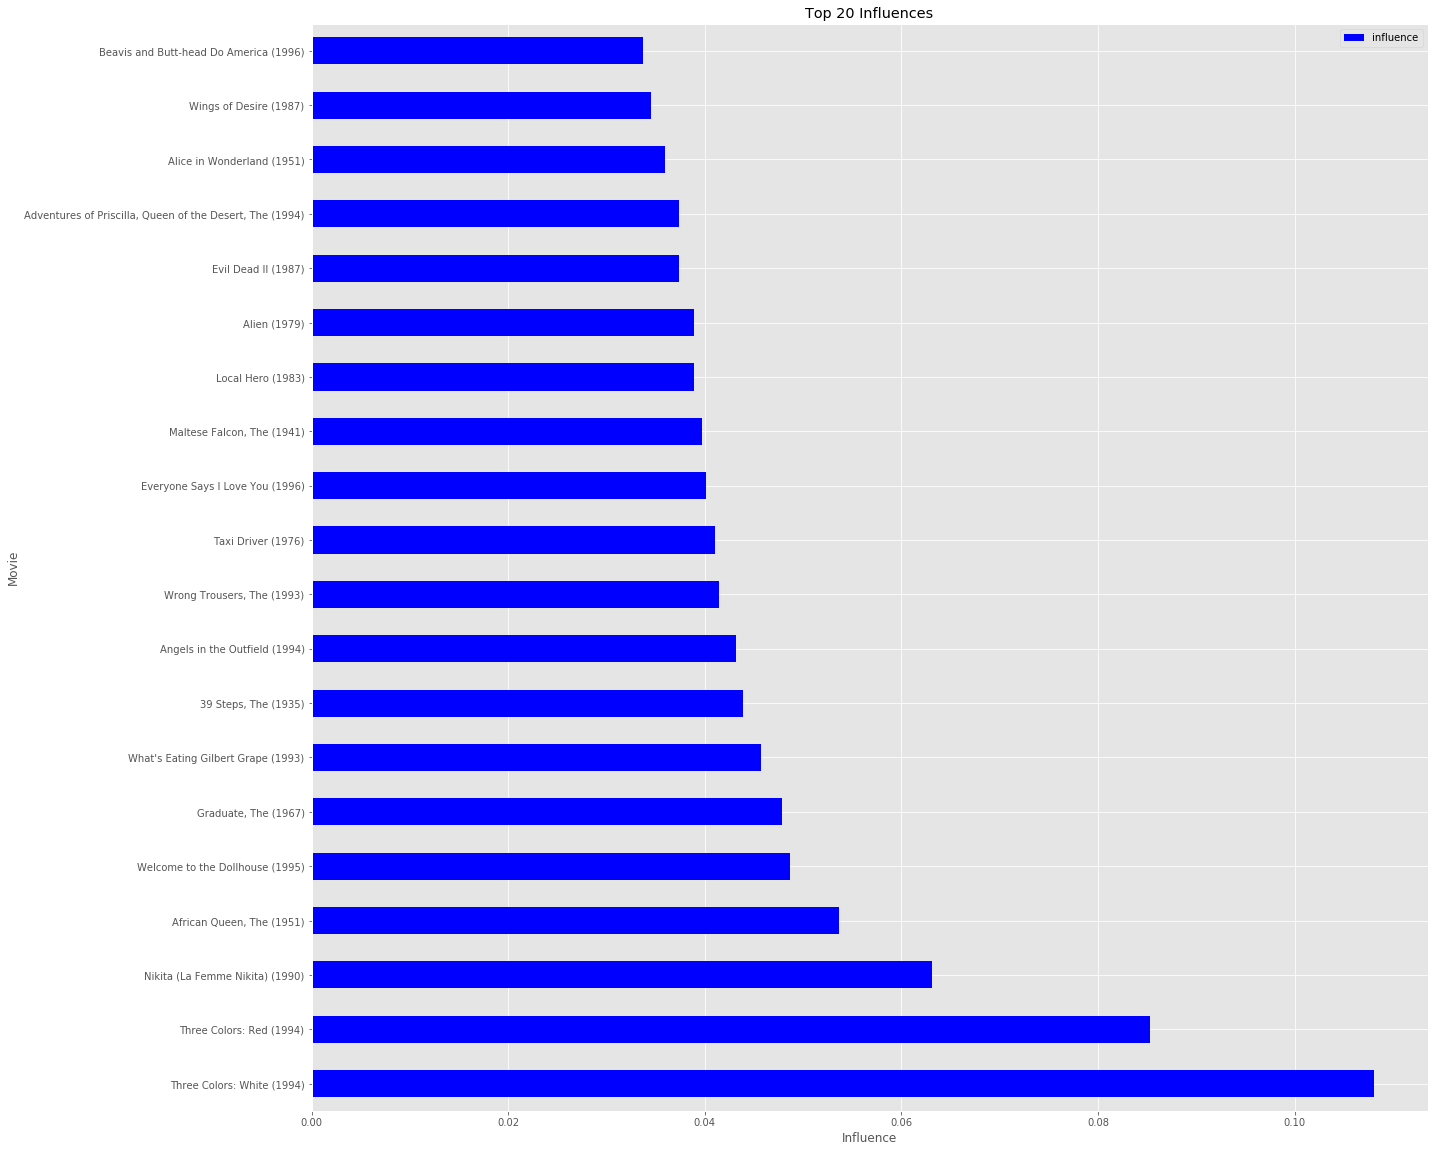

In [48]:
ax = df_top_influence.plot(x ='movie', y='influence', kind = 'barh', figsize=(20,20), title='Top 20 Influences', color='blue')
ax.set_ylabel("Movie")
ax.set_xlabel("Influence")

These influences seem to make sense.  The first two are the other movies in the same trilogy, and the others seem to make sense if you're a movie fan.  `Short Cuts`, for example, is an indie film by Robert Altman, which might appeal to the people who liked the 'Three Colors' trilogy.''

### Look up influence for new recommendation

Now let's consider a movie that the user hasn't seen before.

In [49]:
np.sort(u_all)[:5]

array([ 2,  4,  8, 11, 12])

In [50]:
movie_to_rate = 9

In [51]:
rate_data = np.zeros((1, nb_features))

In [52]:
rate_data[0, user_of_interest-1] = 1.0

In [53]:
rate_data[0, nb_users + movie_to_rate -1] = 1.0

In [54]:
result = fm_predictor.predict(rate_data) 

In [55]:
result

{u'predictions': [{u'predicted_label': 1.0, u'score': 0.8761151432991028}]}

The model predicts that the user will like this movie.  Let's see why.

In [56]:
influence_i = J[movie_to_rate-1,:] # movies are indexed at 1, so we offset to 0
influence_i[movie_to_rate-1] = 0.0

In [57]:
df_influence = pd.DataFrame(data={'influence': influence_i, 'movie': df_movies['movie_name']})
df_influence.head(5)

,influence,movie
0,0.000000,Toy Story (1995)
1,0.000000,GoldenEye (1995)
2,0.011760,Four Rooms (1995)
3,0.000000,Get Shorty (1995)
4,0.041085,Copycat (1995)


We're looking at the movie 'Dead Man Walking', which was an acclaimed movie about a prisoner on Death Row.

In [58]:
df_movies[df_movies['movie_id'] == movie_to_rate]

,movie_id,movie_name,c3,c4,c5,c6,c7,c9,c9.1,c10,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_top_influence = df_influence.nlargest(20, 'influence')
df_top_influence

,influence,movie
728,0.078186,Nell (1994)
69,0.070056,Four Weddings and a Funeral (1994)
196,0.068995,"Graduate, The (1967)"
601,0.059554,"American in Paris, An (1951)"
435,0.058832,"American Werewolf in London, An (1981)"
86,0.058775,Searching for Bobby Fischer (1993)
216,0.057781,Bram Stoker's Dracula (1992)
184,0.056102,Psycho (1960)
588,0.056078,"Wild Bunch, The (1969)"
302,0.055011,Ulee's Gold (1997)


Text(0.5,0,'Influence')

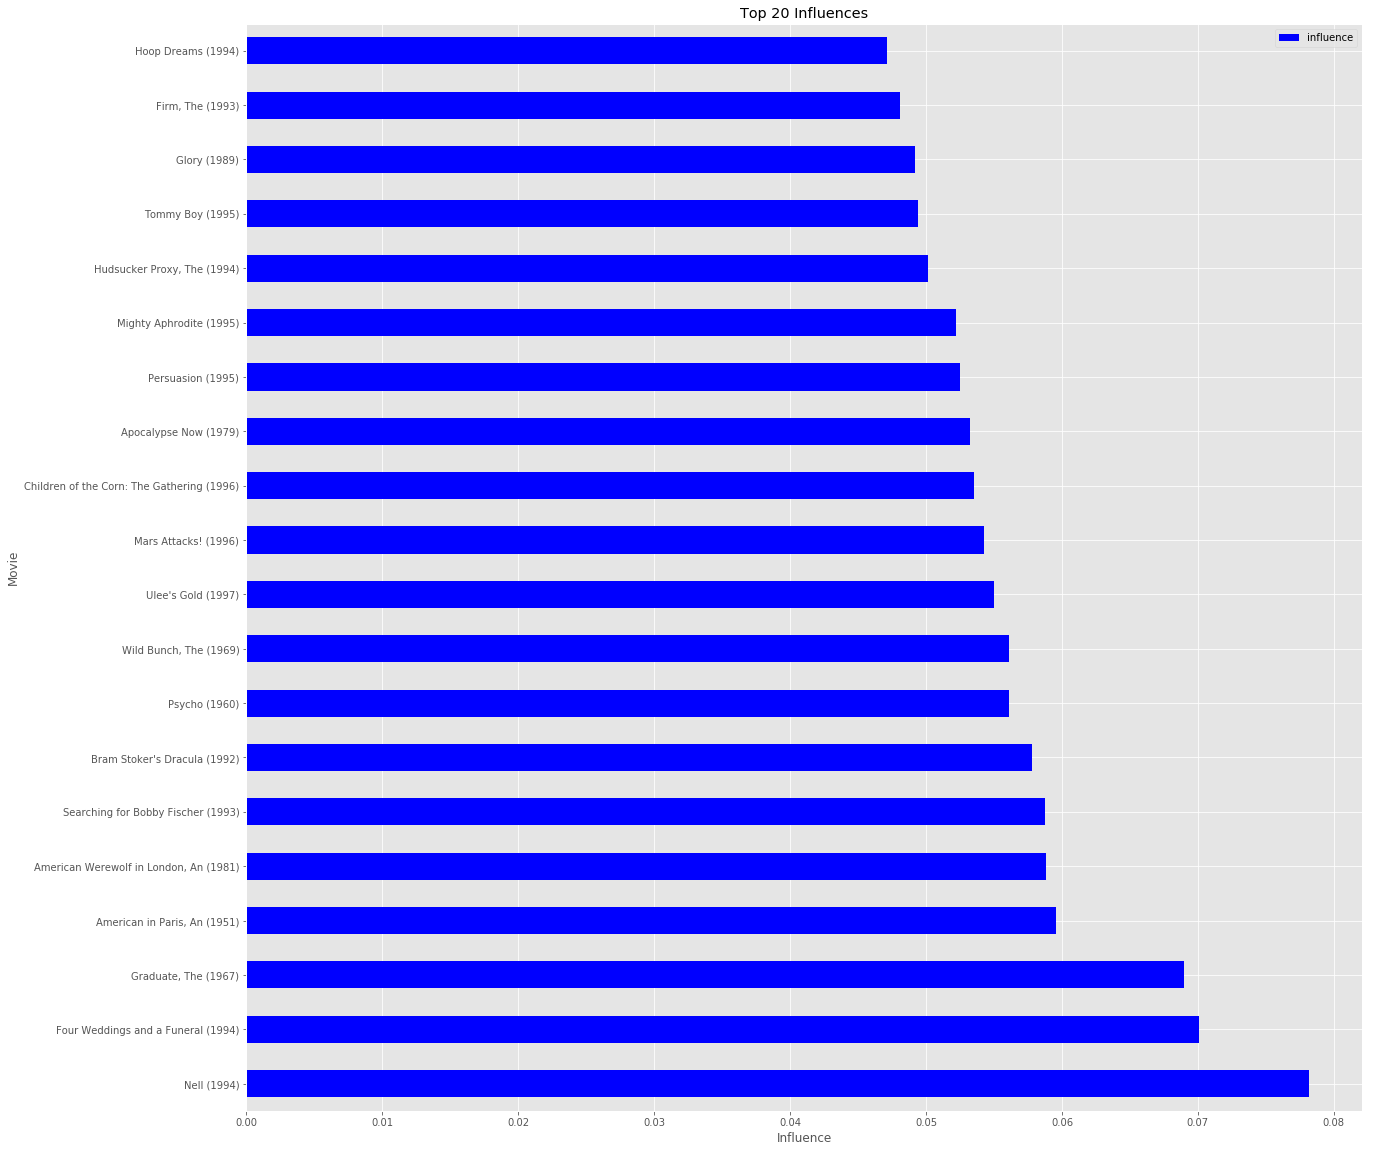

In [60]:
ax = df_top_influence.plot(x ='movie', y='influence', kind = 'barh', figsize=(20,20), title='Top 20 Influences', color='blue')
ax.set_ylabel("Movie")
ax.set_xlabel("Influence")

Are these results intuitively satisfying?  I'm not quite sure, but remember that built this model with a relatively limited data set.